# Vision TransFormer

<div class="author-card">
    <a href="/rokmr">
        <img class="avatar avatar-user" src="https://avatars.githubusercontent.com/u/104412006?v=4" width="100" title="Gravatar">
    </a>
</div>

[<code>rokmr</code>](https://github.com/rokmr)
<span class="fullname">Rohit Kumar</span>

# Introduction

We kow that ViT is only Encoder Model. It consists of several components like:

*   LayerNorm
*   MSA
*   MLP
*   Residual Connection



<p align ="center">
  <img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/Transformer%20Encoder.jpeg", width= 200>
</p>


<p align = "center">
   <img src = "https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/ViT.jpeg", width=600, height=350>
</p>


The following gif illustrate the working of the ViT borrowed from [lucidrains](https://github.com/lucidrains/vit-pytorch)
<p align="center">
  <img src="https://raw.githubusercontent.com/lucidrains/vit-pytorch/main/images/vit.gif", width=600, height=300>
</p>

<p align = "centre">
  <img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/ViT_Equations.png">
</p>

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

**This COLAB NOTEBOOK, will focus on the implementation of the base variant of the ViT* i.e., <code> ViT-Base </code>**
<p align="center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/ViT%20Model%20Variant.jpeg">
</p>

## Getting Data from Hugging Face

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
!pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset, Image

train_dataset = load_dataset("rokmr/pets", split="train")
test_dataset = load_dataset("rokmr/pets", split="test")

print(type(test_dataset))

print(train_dataset)
print(test_dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/rokmr___imagefolder/default-130c53462c803cb4/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['image', 'label'],
    num_rows: 886
})
Dataset({
    features: ['image', 'label'],
    num_rows: 150
})


In [4]:
train_dataset.info.features['label']

ClassLabel(names=['cat', 'dog', 'rabbit'], id=None)

In [5]:
class_names = ['cat', 'dog', 'rabbit']

In [6]:
mini_pets_id2label={0: "cat",
                    1: "dog",
                    2: "rabbit"}

In [7]:
image0 = test_dataset["image"][0]
image1 = test_dataset["image"][62]
image2 = test_dataset["image"][112]

label0 = test_dataset["label"][0]
label1 = test_dataset["label"][62]
label2 = test_dataset["label"][112]

label0, label1, label2

(0, 1, 2)

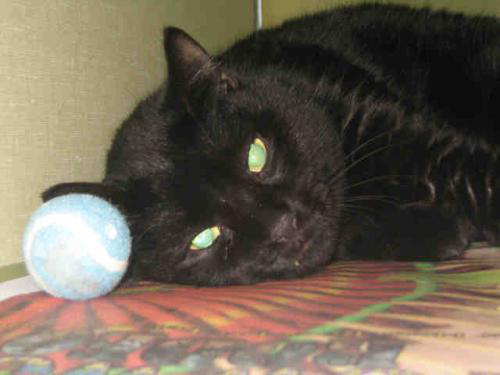

In [8]:
test_dataset[0]["image"]

In [9]:
from torchvision import transforms
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def transforms(examples):
    examples["pixel_values"] = [manual_transforms(image) for image in examples["image"]]
    return examples

test_dataset.set_transform(transforms)
train_dataset.set_transform(transforms)

(-0.5, 223.5, 223.5, -0.5)

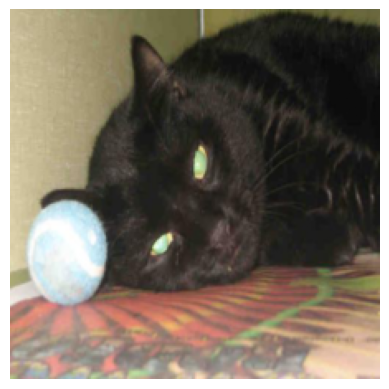

In [10]:
import matplotlib.pyplot as plt
img = test_dataset[0]["pixel_values"]
img = img.permute(1,2,0)
plt.imshow(img.cpu().numpy())
plt.axis(False)

# Equation : 1
##$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$


---
Vector Form input

``` python shell
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```
This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

* D - Embedding Dimension
* N - Number of path
* P - Patch height or width
* C - Color Channel
* $ x_{class} $ - Learnable class token
* $ E_{pos}$ - Positional Embedding

[NOTE] : Each element of embedding is learnable so we need to keep their grad active (require_grad = [True]()).  

**Embeddings are learnable representations of data**

<p align = "center">
   <img src = "https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/Patch.jpeg", width=600, height=200>
</p>

In [11]:
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
#Input image shape
embedding_layer_input_shape = (height, width, color_channels)
print(f"embedding_layer_input_shape: {embedding_layer_input_shape}")

# Output of embedding layer shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"embedding_layer_output_shape: {embedding_layer_output_shape}")

embedding_layer_input_shape: (224, 224, 3)
embedding_layer_output_shape: (196, 768)


Basically here we get 768 which in turn be dimension of D for this transformer.

In [13]:
image = test_dataset[0]["pixel_values"]
label = test_dataset[0]["label"]

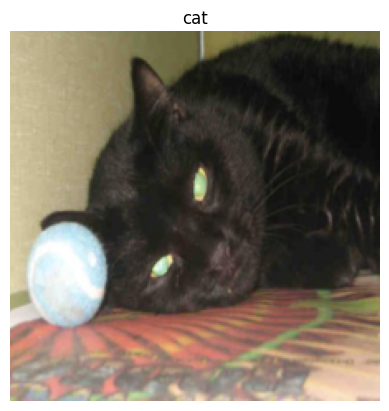

In [14]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

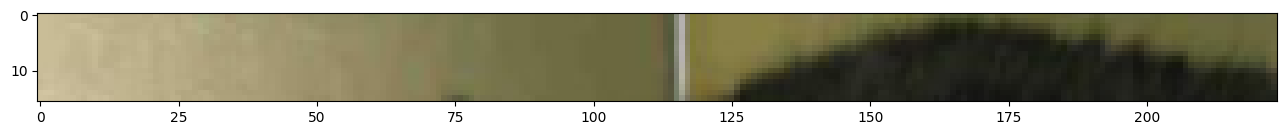

In [15]:
image_permuted = image.permute(1, 2, 0) #(color_channels, height, width) -> (height, width, color_channels)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [16]:
# HYPER-PARAMETER (Assuming Squared Shaped Image)
img_size = 224
patch_size = 16
num_patches_per_row = img_size/patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"
num_patches_per_row = int(num_patches_per_row)
print(f"Number of patches per row in IMAGE: {num_patches_per_row}")

Number of patches per row in IMAGE: 14


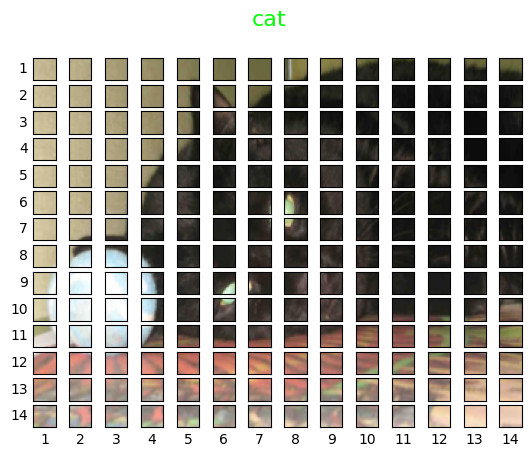

In [17]:
fig, axs = plt.subplots(nrows= num_patches_per_row,
                        ncols= num_patches_per_row,
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)): # height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # width

        axs[i, j].imshow(image_permuted[ patch_height: patch_height+patch_size, patch_width: patch_width+patch_size, :])
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([]) #indexing at x axis is set to empty
        axs[i, j].set_yticks([])
        axs[i, j].label_outer() #Only show "outer" labels and tick labels.

fig.suptitle(f"{class_names[label]}", fontsize=16, color ="lime")
plt.show()

<p align="center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/Hybrid%20Architecture2.jpeg">
</p>

**We will be go on Hybrid Model**

In [18]:
from torch import nn
patch_size=16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

(-0.5, 223.5, 223.5, -0.5)

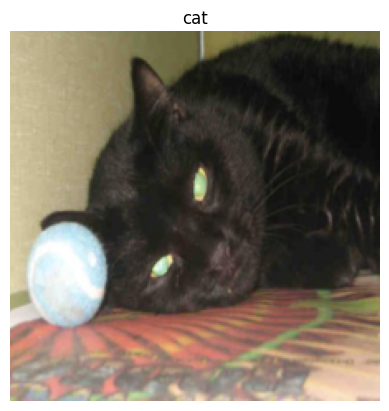

In [19]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [20]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # Unsqueeze for increasing dimension as single image does not have batch dimension
print(image_out_of_conv.shape)
print(image_out_of_conv.requires_grad)

torch.Size([1, 768, 14, 14])
True


**This output and the output obtained through patching is similar. While this method is more convenient and effective as these have feature map which can be considered a learnable embedding of image.**

* **Desried output (flattened 2D patches):** (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* **Current shape:** (1, 768, 14, 14)

In [21]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(image_out_of_conv_flattened.shape)

image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(image_out_of_conv_flattened_reshaped.shape)

torch.Size([1, 768, 196])
torch.Size([1, 196, 768])


## Summing up Patch Embedding

In [22]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector."""
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [23]:
patchify = PatchEmbedding()
patch_embedded_image = patchify(image.unsqueeze(0))
print(image.unsqueeze(0).shape)
print(patch_embedded_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


## Class Token

In [24]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) #Learnable

# Concatinating to the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)
print(patch_embedded_image.shape)
print(patch_embedded_image_with_class_embedding.shape)

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])


## Positional Embedding : Learnable

[**What Do Position Embeddings Learn?**](https://arxiv.org/pdf/2010.04903.pdf)

Given the position space P and the embedding
space X , the goal of the position embedding function is to learn a mapping f : P → X .



Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

In [25]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # learnable

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(position_embedding.shape)
print(patch_and_position_embedding.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


## Equation 1 : Summary

In [26]:
patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# Equation : 2

##$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

### LN
* Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

* Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

* Rather than normalizing on the batch dimension(BN). Here were are normalizing along embedding dimension(LN).

* Unlike batch normalization, Layer Normalization directly estimates the normalization statistics from the summed inputs to the neurons within a hidden layer so the normalization does not introduce any new dependencies between training cases.

<p align="center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/layer%20Norm.png", width=400,height=400>
</p>

For more details visit [layer normalization](https://paperswithcode.com/method/layer-normalization)


###MSA

![MSA](https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/MSA.jpeg)


<p align ="center">
  <img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/Transformer%20Encoder.jpeg", width= 100>
</p>

**query, key, value** input or **qkv** for short which is fundamental to the self-attention mechanism.

The triple embedding input will be three versions of the output of the Norm layer, one for query, key and value or three versions of our layer-normalized image patch and position embeddings.

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:
* `embed_dim` - the embedding dimension (Hidden size $D$).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from)(Heads).
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
* `batch_first` - does our batch dimension come first? (yes it does)

### CODE
For LayerNorm and MSA will be using torch inbuilt function.

[nn.LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

[nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)

In [27]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a MSA block """
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0): # according to Appendix B.1, dropout isn't used after the qkv-projections
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [28]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(patch_and_position_embedding.shape)
print(patched_image_through_msa_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


**Residual Connection is not implemented till now**

#Equation : 3
##$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

**As per 3.1 section, MLP is described : The MLP contains two layers with a GELU non-linearity**

**As per Table-3, dropout : 0.1**

In [29]:
class MLPBlock(nn.Module):
    """Creates a MLP layer"""
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [30]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(patched_image_through_msa_block.shape)
print(patched_image_through_mlp_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


**Residual Connection is still need to made for this block also.**

## ENCODER
We need our encoder look like

 `MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] `


In [31]:
!pip install -q -U torchinfo

In [32]:
from torchinfo import summary

In [33]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x      #Residual Connection
        x = self.mlp_block(x) + x       #Residual Connection
        return x

In [35]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [38]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

#Equation : 4

##$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$



```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

<p align = "center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/classification%20head.jpeg">
</p>



In [50]:
class ClassifierHead(nn.Module):
  """Creates a Classifier ViT."""
  def __init__(self,
               embedding_dim: int= 768,
               num_classes:int = 1000):
    super().__init__()
    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim,
                                              out_features=num_classes))

  def forward(self, x):
    x = self.classifier(x)
    return x

# ViT

**DropOut for ViT**
<p align = "center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/DropOut.jpeg">
</p>

In [51]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Stack 12 (num_transformer_layers) Transformer Encoder blocks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = ClassifierHead(embedding_dim=embedding_dim,
                                         num_classes=num_classes)

    def forward(self, x):

        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) # creates copies of the class embedding batch_size times along 0th dim keeping first and second same

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) # Keeping all batch and taking the first element of x from 197
        return x

In [52]:
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[ 0.5620, -0.4778, -0.4936]], grad_fn=<AddmmBackward0>)

In [53]:
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# Training

**Training Details**
<p align = "center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/Training.jpeg">
</p>

**Loss**
Not able to find loss in paper. Got loss from official implementation
<p align = "center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/Loss.jpeg">
</p>
**Weight decay, DropOut etc**
<p align = "center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/heading.jpeg">
</p>
<p align = "center">
<img src="https://raw.githubusercontent.com/rokmr/Deep-Learning-In-Computer-Vision/main/ViT/colab_Images/weight_decay.jpeg">
</p>

**Hyper Parameters:**

Optimizer : Adam with β1=0.9,β2=0.999

lr : 3 * ${10^{-3}}$

weight_decay; 0.3

loss: Cross Entropy



In [57]:
num_params = sum(param.numel() for param in vit.parameters())
num_params

85800963

In [ ]:
# HYPER-PARAMETERS
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

#Resources


1.   [AN IMAGE IS WORTH 16X16 WORDS](https://arxiv.org/pdf/2010.11929.pdf)
2.   [lucidrains github repo](https://github.com/lucidrains/vit-pytorch)
3.   [Google ViT github repo](https://github.com/google-research/vision_transformer)
4.   [Daniel Bourke Book](https://www.learnpytorch.io/)
